In [1]:
# 导入相关包
import time
import numpy as np
np.random.seed(1)
import pandas as pd
import json
import matplotlib.pyplot as plt
import boto3
import s3fs
import sagemaker
from sagemaker import get_execution_role

In [2]:
# 设置s3存储数据位置
prefix = 'lpr/Elderly-deepar'

sagemaker_session = sagemaker.Session()
role = get_execution_role()
bucket = sagemaker_session.default_bucket()

s3_data_path = "{}/{}/data".format(bucket, prefix)
s3_output_path = "{}/{}/output".format(bucket, prefix)

In [3]:
# 使用内置算法forecasting-deepar进行数据预测
from sagemaker.amazon.amazon_estimator import get_image_uri
image_name = get_image_uri(boto3.Session().region_name, 'forecasting-deepar')

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


In [4]:
freq = 'H'
prediction_length = 48

In [5]:
context_length = 72

In [6]:
t0 = '2020-09-01 00:00:00'
data_length = 400
num_ts = 200
period = 24

In [91]:
# 生成数据
time_series = []
for k in range(num_ts):
    level = 150 * np.random.rand()
    seas_amplitude = (1 + 0.3*np.random.rand()) * level
    sig = 0.005 * level # 噪点
    time_ticks = np.array(range(data_length))
    source = level + seas_amplitude*np.sin(time_ticks/period/2000)
    noise = sig*np.random.randn(data_length)
    data = source + noise
    index = pd.date_range(start=t0, freq=freq, periods=data_length)
    time_series.append(pd.Series(data=data, index=index))

In [94]:
time_series[0]

2020-09-01 00:00:00    114.684729
2020-09-01 01:00:00    113.980506
2020-09-01 02:00:00    114.323596
2020-09-01 03:00:00    114.995357
2020-09-01 04:00:00    114.730439
                          ...    
2020-09-17 11:00:00    115.510475
2020-09-17 12:00:00    115.503586
2020-09-17 13:00:00    115.775045
2020-09-17 14:00:00    116.208944
2020-09-17 15:00:00    115.405255
Freq: H, Length: 400, dtype: float64

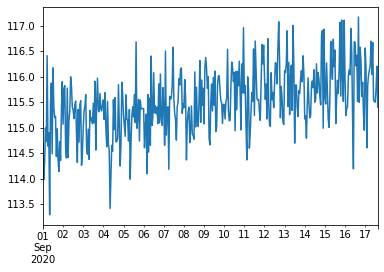

In [95]:
# 模拟老人的收缩压
time_series[0].plot()
plt.show()

In [96]:
# 进行训练的数据 切走后面48小时的数据
time_series_training = []
for ts in time_series:
    time_series_training.append(ts[:-prediction_length])

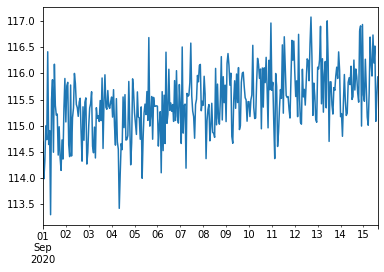

In [97]:
time_series_training[0].plot()
plt.show()

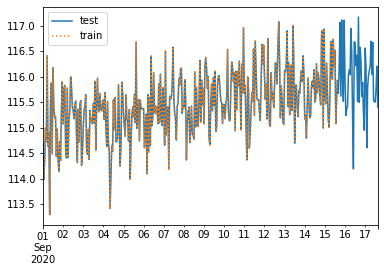

In [98]:
time_series[0].plot(label='test')
time_series_training[0].plot(label='train', ls=':')
plt.legend()
plt.show()

In [99]:
def series_to_obj(ts, cat=None):
    obj = {"start": str(ts.index[0]), "target": list(ts)}
    if cat is not None:
        obj["cat"] = cat
    return obj

def series_to_jsonline(ts, cat=None):
    return json.dumps(series_to_obj(ts, cat))

In [100]:
encoding = "utf-8"
s3filesystem = s3fs.S3FileSystem()

# 将训练数据和测试数据存到s3
with s3filesystem.open(s3_data_path + "/train/train.json", 'wb') as fp:
    for ts in time_series_training:
        fp.write(series_to_jsonline(ts).encode(encoding))
        fp.write('\n'.encode(encoding))

with s3filesystem.open(s3_data_path + "/test/test.json", 'wb') as fp:
    for ts in time_series:
        fp.write(series_to_jsonline(ts).encode(encoding))
        fp.write('\n'.encode(encoding))

In [102]:
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.xlarge',
    base_job_name='lpr-deepar',
    output_path="s3://" + s3_output_path
)

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


In [178]:
hyperparameters = {
    "time_freq": freq,
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "num_cells": "40",
    "num_layers": "3",
    "likelihood": "gaussian",
    "epochs": "20",
    "mini_batch_size": "32",
    "learning_rate": "0.014",
    "dropout_rate": "0.05",
    "early_stopping_patience": "10"
}

In [179]:
estimator.set_hyperparameters(**hyperparameters)

In [180]:
# 进行训练任务
data_channels = {
    "train": "s3://{}/train/".format(s3_data_path),
    "test": "s3://{}/test/".format(s3_data_path)
}

estimator.fit(inputs=data_channels)

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2020-09-15 09:59:27 Starting - Starting the training job...
2020-09-15 09:59:34 Starting - Launching requested ML instances......
2020-09-15 10:00:36 Starting - Preparing the instances for training.........
2020-09-15 10:02:12 Downloading - Downloading input data...
2020-09-15 10:02:42 Training - Downloading the training image.Arguments: train
[09/15/2020 10:02:57 INFO 139774100076352] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': u''}
[09/15/2020 10:02

In [181]:
# 创建终端节点
job_name = estimator.latest_training_job.name

endpoint_name = sagemaker_session.endpoint_from_job(
    job_name=job_name,
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    deployment_image=image_name,
    role=role
)

---------------!

In [182]:
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):

    def set_prediction_parameters(self, freq, prediction_length):
        """设置时间频率和预测长度参数。 调用此方法
         必须在使用`predict`之前。
        
        参数:
        freq -- 指示时间频率的字符串
        prediction_length -- 整数，预计时间点数
        """
        self.freq = freq
        self.prediction_length = prediction_length
        
    def predict(self, ts, cat=None, encoding="utf-8", num_samples=100, quantiles=["0.1", "0.5", "0.9"]):
        """请求对“ ts”中列出的时间序列进行预测
        
        参数:
        ts -- pandas.Series对象列表，可预测的时间序列
        cat -- 整数列表（默认值：无）
        encoding -- 字符串，用于请求的编码（默认值：“ utf-8”）
        num_samples -- 整数，在预测时要计算的样本数（默认值：100）
        quantiles -- 指定要计算的分位数的字符串列表（默认：[“ 0.1”，“ 0.5”，“ 0.9”]）
        
        返回: pandas.DataFrame对象的列表，每个对象都包含预测
        """
        prediction_times = [x.index[-1]+pd.Timedelta(1, unit=self.freq) for x in ts]
        req = self.__encode_request(ts, cat, encoding, num_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, prediction_times, encoding)
    
    def __encode_request(self, ts, cat, encoding, num_samples, quantiles):
        instances = [series_to_obj(ts[k], cat[k] if cat else None) for k in range(len(ts))]
        configuration = {"num_samples": num_samples, "output_types": ["quantiles"], "quantiles": quantiles}
        http_request_data = {"instances": instances, "configuration": configuration}
        return json.dumps(http_request_data).encode(encoding)
    
    def __decode_response(self, response, prediction_times, encoding):
        response_data = json.loads(response.decode(encoding))
        list_of_df = []
        for k in range(len(prediction_times)):
            prediction_index = pd.date_range(start=prediction_times[k], freq=self.freq, periods=self.prediction_length)
            list_of_df.append(pd.DataFrame(data=response_data['predictions'][k]['quantiles'], index=prediction_index))
        return list_of_df

In [183]:
predictor = DeepARPredictor(
    endpoint=endpoint_name,
    sagemaker_session=sagemaker_session,
    content_type="application/json"
)
predictor.set_prediction_parameters(freq, prediction_length)

In [184]:
# 取前5组数据进行预测
len(time_series_training[:5])

5

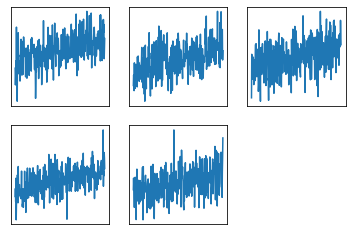

In [185]:
# 预览前5组数据
plt.figure()
for i in range(5):
    ##将小图分成2行2列,第三个参数表示第n个图
    plt.subplot(2,3,i+1)
    #设置小图的x,y坐标
    plt.plot(time_series_training[i])
    plt.xticks([])
    plt.yticks([])
plt.show()

In [186]:
list_of_df = predictor.predict(time_series_training[:5])
actual_data = time_series[:5]

In [187]:
list_of_df

[                            0.1         0.9         0.5
 2020-09-15 16:00:00  109.618805  119.650276  114.841759
 2020-09-15 17:00:00  111.111977  118.695213  115.363564
 2020-09-15 18:00:00  109.537338  119.537781  114.257874
 2020-09-15 19:00:00  109.425247  119.731613  114.290581
 2020-09-15 20:00:00  110.602982  119.915047  114.681694
 2020-09-15 21:00:00  111.008171  120.078873  115.048393
 2020-09-15 22:00:00  111.331848  120.017532  115.589294
 2020-09-15 23:00:00  110.501633  118.785423  114.782433
 2020-09-16 00:00:00  110.571609  119.482300  115.228546
 2020-09-16 01:00:00  110.391556  119.484863  115.048759
 2020-09-16 02:00:00  110.076904  120.262993  114.556152
 2020-09-16 03:00:00  110.491127  120.094200  115.147926
 2020-09-16 04:00:00  109.796982  119.284714  115.364822
 2020-09-16 05:00:00  111.950104  120.621643  116.070404
 2020-09-16 06:00:00  108.803909  119.831520  114.552940
 2020-09-16 07:00:00  110.617897  120.466530  114.612549
 2020-09-16 08:00:00  109.85749

In [188]:
actual_data

[2020-09-01 00:00:00    114.684729
 2020-09-01 01:00:00    113.980506
 2020-09-01 02:00:00    114.323596
 2020-09-01 03:00:00    114.995357
 2020-09-01 04:00:00    114.730439
                           ...    
 2020-09-17 11:00:00    115.510475
 2020-09-17 12:00:00    115.503586
 2020-09-17 13:00:00    115.775045
 2020-09-17 14:00:00    116.208944
 2020-09-17 15:00:00    115.405255
 Freq: H, Length: 400, dtype: float64,
 2020-09-01 00:00:00    94.509951
 2020-09-01 01:00:00    94.867177
 2020-09-01 02:00:00    94.808135
 2020-09-01 03:00:00    94.327173
 2020-09-01 04:00:00    95.301840
                          ...    
 2020-09-17 11:00:00    95.773236
 2020-09-17 12:00:00    95.175815
 2020-09-17 13:00:00    96.200919
 2020-09-17 14:00:00    95.609396
 2020-09-17 15:00:00    96.011424
 Freq: H, Length: 400, dtype: float64,
 2020-09-01 00:00:00    63.892876
 2020-09-01 01:00:00    64.813673
 2020-09-01 02:00:00    64.767470
 2020-09-01 03:00:00    64.777741
 2020-09-01 04:00:00    64.

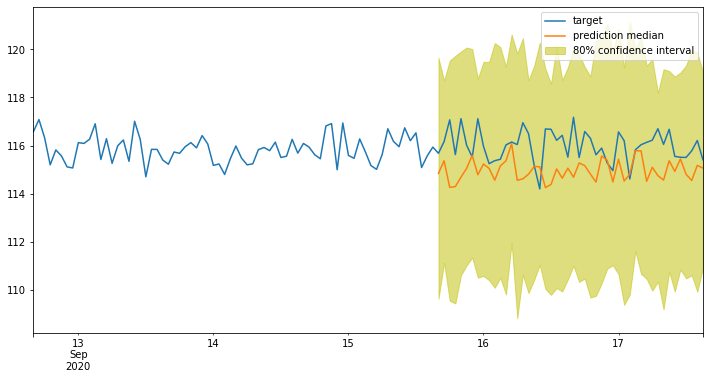

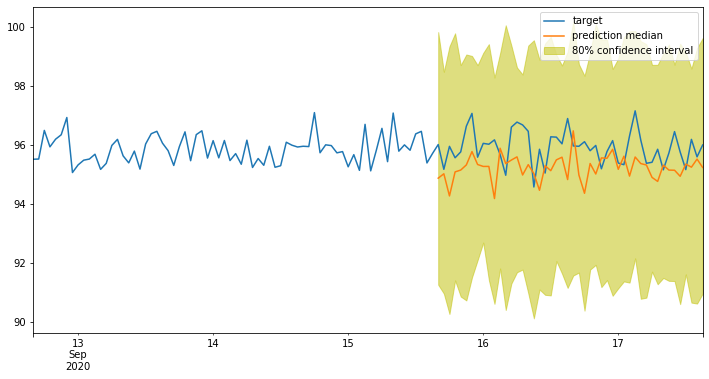

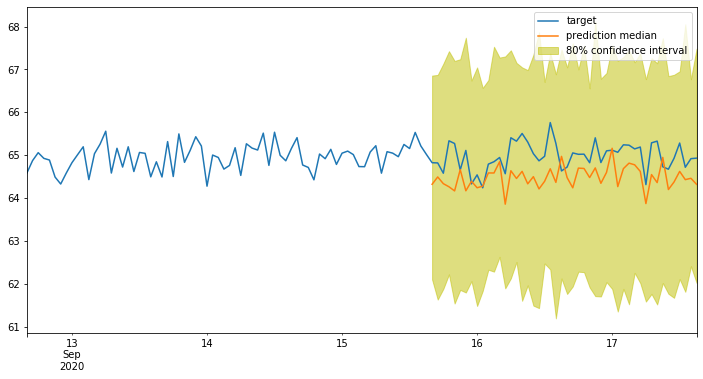

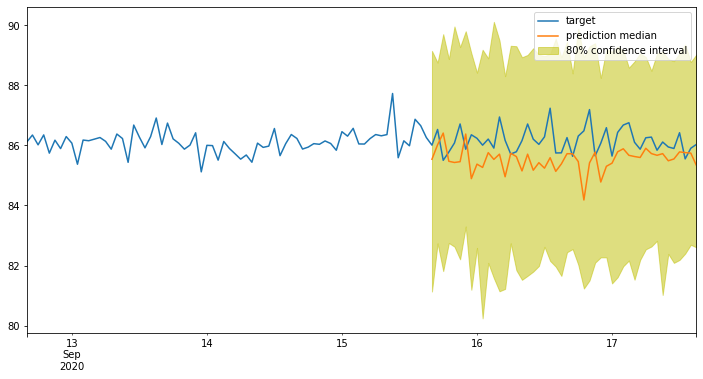

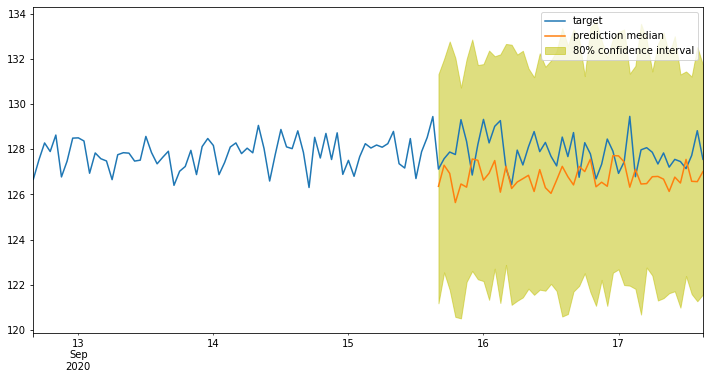

In [189]:
for k in range(len(list_of_df)):
    plt.figure(figsize=(12,6))
    actual_data[k][-prediction_length-context_length:].plot(label='target')
    p10 = list_of_df[k]['0.1']
    p90 = list_of_df[k]['0.9']
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
    list_of_df[k]['0.5'].plot(label='prediction median')
    plt.legend()
    plt.show()

In [177]:
sagemaker_session.delete_endpoint(endpoint_name)